In [ ]:
# Afrah Ali - 300049798 - aali179@uottawa.ca 
# Ribhav Khosla - 300087647 - rkhos052@uottawa.ca 
# Zain Malik - 300071476 - zmali081@uottawa.ca 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
# we can use the LabelEncoder to encode the gender feature
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# importing two different imputation methods that take into consideration all the features when predicting the missing values
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

# oversample the minority class using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(42)

##### Data loading and exploratory analysis (18/100)

Dataframe shape:  (260, 16)
['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
Class distribution:
happy        65
sad          65
stressful    65
calm         65
Name: mood, dtype: int64
          track_name               artist                track_id  \
0        Upside Down         Jack Johnson  6shRGWCtBUOPFLFTTqXZIC   
1        Someone New               Hozier  0efT4YKQLQx2YHbp6vgRX8   
2       Little Talks  Of Monsters and Men  3a2tuvXCHbW5nuUckuHkKT   
3    Heart's Content       Brandi Carlile  0pegFWSUOTiG0sLVEfxtvA   
4     Sunday Morning             Maroon 5  4T5cqerbDXueYSVfXkIITo   
..               ...                  ...                     ...   
255    am ersten Tag       Hugo Vanbrooke  2gwhISMkdlhEqEP60P93Z1   
256    Amour naturel       Massimo Pavoni  39bh8hsTP2ZBQWH0E308rT   
257      Dawn Of Day          Sarah Seing  635M2GuMSoVunGBe7D7vWz   
258         Lumino

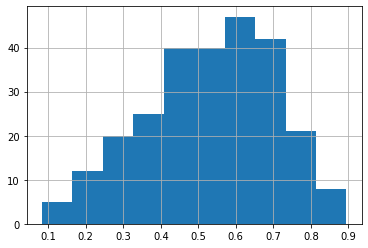

In [2]:
# load the dataset
df = pd.read_csv('dataset.csv')
# print the dimensionality of the dataframe (1)
print('Dataframe shape: ', df.shape)
# print the names of the columns that can be used as features when training the machine learning model (1)
# dropping non-features
dataset = df.drop(columns=['mood', 'track_name', 'artist', 'track_id'])
columns = list(dataset.columns)
print(columns)

print("Class distribution:")
print(df['mood'].value_counts())

#Label encoder
le = LabelEncoder()
df['mood_N'] = le.fit_transform(df['mood'])
df = df.drop(columns=['mood'])
df = df.rename(columns={'mood_N': 'mood'})
print(df)

# split dataset for training and testing
target = df['mood']
print(target)
# Set Training and Testing Data as 8:2
x_train, x_test, y_train, y_test = train_test_split(dataset , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)
# Show the Training and Testing Data
print('Shape of training feature:', x_train.shape)
print('Shape of testing feature:', x_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

# By analysing the features, the feature that has the closest rough approximation of Gaussian distribution is the danceability feature
dataset["danceability"].hist()

# identify features that represent a notable correlation (i.e., either positive or negative correlation below or above -0.5 and 0.5) (3)
# TODO: possibly drop correlated features
print("Features with notable correlation: ")
all_corr = dataset.corr()
for i in range(len(all_corr)):
    for j in range(i):
        if all_corr.iloc[i, j] > 0.5 or all_corr.iloc[i, j] < -0.5:
            print(str(all_corr.columns[i]) + " and " + str(all_corr.columns[j]) + " = " + str(all_corr.iloc[i, j]))

# Comparing energy values across moods
print("Mean energy for happy songs:", df.loc[df['mood'] == 'happy']['energy'].mean())
print("Mean energy for calm songs:", df.loc[df['mood'] == 'calm']['energy'].mean())
print("Mean energy for stressful songs:", df.loc[df['mood'] == 'stressful']['energy'].mean())
print("Mean energy for sad songs:", df.loc[df['mood'] == 'sad']['energy'].mean())

# Proportional class distribution

print("Class distribution of train set: ", y_train.value_counts())
print("Class distribution of test set: ", y_test.value_counts())


##### Model development (64/100)

In [3]:
# Scaling numerical data

#Numerical pipeline for all data
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

# Sending data through pipeline to get fully transformed data
# 2D Numpy array
columns_transformed = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
train_data_transformed = pd.DataFrame(num_pipeline.fit_transform(x_train), columns=columns_transformed)
print(train_data_transformed)

# Creating pipelines for models
pipeline_svm = Pipeline([('scaler', StandardScaler())])
pipeline_dtc = Pipeline([('scaler', StandardScaler())])
pipeline_rfc = Pipeline([('scaler', StandardScaler())])
pipeline_gnb = Pipeline([('scaler', StandardScaler())])

     acousticness  danceability    energy  instrumentalness       key  \
0       -0.514931      1.492572  0.722318         -0.521550  0.840425   
1       -1.219636     -0.862821  1.798226          0.938070 -1.130040   
2        0.624283      0.145786 -1.325003         -0.513296 -0.567050   
3       -1.151568      0.869609  1.028061         -0.522125  0.840425   
4       -1.195381      0.181384  1.666640         -0.522150 -0.567050   
..            ...           ...       ...               ...       ...   
203     -1.204702      0.549228  1.763394         -0.522150  1.684910   
204      1.622533     -1.729035 -1.855216          2.741031 -0.567050   
205      1.490200     -1.645974 -0.740607          1.891319 -0.004060   
206     -0.799735      1.878216  0.335301         -0.522150 -0.004060   
207     -1.109279      1.130660  1.105465         -0.522150 -1.130040   

     liveness  loudness      mode  speechiness     tempo  time_signature  \
0   -0.338574  1.054692  0.814862    -0.462733 

In [4]:
# create the following four different models with their default hyperparameter values to be trained using the preprocessed data (0.5 * 4)
# Support Vector Machine
svm = SVC()
pipeline_svm.steps.append(['model', svm])
# Decision Trees
dtc = DecisionTreeClassifier()
pipeline_dtc.steps.append(['model', dtc])
# Random Forests
rfc = RandomForestClassifier()
pipeline_rfc.steps.append(['model', rfc])
# Naive Bayes
gnb = GaussianNB()
pipeline_gnb.steps.append(['model', gnb])


In [26]:
# This cell should take 3-5 minutes to run

# use sklearn GridSearchCV to train your selected model with hyperparameter tuning
# state briefly the advantage of using cross-validation in the markdown cell below (2)

# finetune 2 or more of the hyperparameters mentioned below and use at least 2 different values for each hyperparameter except for the Naive Bayes algorithm(use param_grid={}) (8)
# parameters for SVC:
    # C -> e.g., 10, 100
    # gamma ->  e.g., 0.001, 0.0001
    # kernel -> 'rbf' or 'linear' 
gscv_svm = GridSearchCV(pipeline_svm, param_grid={
    'model__kernel':['linear', 'rbf'], 
    'model__C':[50,60,70,80,90,100,110,120,130,140], 
    'model__gamma':[ 0.01, 0.001, 0.0001,]})

# parameters for DecisionTreeClassifier: 
    # max_depth ->  e.g., 3, 4
    # min_samples_split -> 5, 10
    # min_samples_leaf -> 10, 20

gscv_dtc = GridSearchCV(pipeline_dtc, param_grid={
    'model__max_depth':[1,2,3,4,5,6,7,8,9,10], 
    'model__min_samples_split':[25,35,45,55,65,75,85,95], 
    'model__min_samples_leaf':[10,15,20,25,30,35,40]})

# parameters for RandomForestClassifier: 
    # n_estimators -> 100, 200
    # max_depth -> 3, 5
    # bootstrap -> True, False
gscv_rfc = GridSearchCV(pipeline_rfc, param_grid={
    'model__n_estimators':[1,5,10,15,20,25,30,35,40], 
    'model__max_depth':[ 3,5,7,9,11,13,15,17,19,21,23,25,27,29], 
    'model__bootstrap':[True, False]})

# parameters for Naive Bayes:
gscv_gnb = GridSearchCV(pipeline_gnb, param_grid={})

# initialize gridsearch with the required parameters, including the following scoring methods and refit='bal_accuracy' (2)
scoring = {"accuracy": "accuracy", "bal_accuracy": "balanced_accuracy", "F1_macro": "f1_macro"}
gscv_svm.set_params(scoring=scoring, refit='bal_accuracy')
gscv_dtc.set_params(scoring=scoring, refit='bal_accuracy')
gscv_rfc.set_params(scoring=scoring, refit='bal_accuracy')
gscv_gnb.set_params(scoring=scoring, refit='bal_accuracy')

# fit the training data (0.5)
gscv_svm.fit(train_data_transformed, y_train)
gscv_dtc.fit(train_data_transformed, y_train)
gscv_rfc.fit(train_data_transformed, y_train)
gscv_gnb.fit(train_data_transformed, y_train)

# print the best parameters (0.5)
print("Support Vector Machine Best Parameters: ", gscv_svm.best_params_)
print("Decision Trees Best Parameters: ", gscv_dtc.best_params_)
print("Random Forests Best Parameters: ", gscv_rfc.best_params_)
print("Naive Bayes Best Parameters: ", gscv_gnb.best_params_)

# print the best estimator (0.5)
print("Support Vector Machine Best Estimator: ", gscv_svm.best_estimator_)
print("Decision Trees Best Estimator: ", gscv_dtc.best_estimator_)
print("Random Forests Best Estimator: ", gscv_rfc.best_estimator_)
print("Naive Bayes Best Estimator: ", gscv_gnb.best_estimator_)

# print the best score from trained GridSearchCV model (0.5)
print("Support Vector Machine Best Score: ", gscv_svm.best_score_)
print("Decision Trees Best Score: ", gscv_dtc.best_score_)
print("Random Forests Best Score: ", gscv_rfc.best_score_)
print("Naive Bayes Best Score: ", gscv_gnb.best_score_)

Support Vector Machine Best Parameters:  {'model__C': 100, 'model__gamma': 0.0001, 'model__kernel': 'rbf'}
Decision Trees Best Parameters:  {'model__max_depth': 5, 'model__min_samples_leaf': 15, 'model__min_samples_split': 25}
Random Forests Best Parameters:  {'model__bootstrap': True, 'model__max_depth': 15, 'model__n_estimators': 35}
Naive Bayes Best Parameters:  {}
Support Vector Machine Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model', SVC(C=100, gamma=0.0001)]])
Decision Trees Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=15,
                                        min_samples_split=25)]])
Random Forests Best Estimator:  Pipeline(steps=[('scaler', StandardScaler()),
                ['model',
                 RandomForestClassifier(max_depth=15, n_estimators=35)]])
Naive Bayes Best Estimator:  Pipeline(steps=[('scaler', StandardScal

In [27]:
# print the grid search cross-validation results listing the above mentioned evaluation methods (3)
print("Support Vector Machine Results: ", gscv_svm.cv_results_)
print("Decision Trees Results: ", gscv_dtc.cv_results_)
print("Random Forests Results: ", gscv_rfc.cv_results_)
print("Naive Bayes Results: ", gscv_gnb.cv_results_)

Support Vector Machine Results:  {'mean_fit_time': array([0.06300397, 0.00675359, 0.04812059, 0.0053205 , 0.05223927,
       0.00561571, 0.05219374, 0.00525875, 0.05265303, 0.00524521,
       0.05352774, 0.0052146 , 0.05884428, 0.00502725, 0.05755615,
       0.00487199, 0.05771704, 0.00498157, 0.07178855, 0.00511608,
       0.0717865 , 0.00469799, 0.07290974, 0.00504246, 0.07211256,
       0.0067874 , 0.07004719, 0.00445042, 0.07244248, 0.00532184,
       0.0847158 , 0.00563855, 0.08259478, 0.00496397, 0.07992954,
       0.00430422, 0.0809442 , 0.00599833, 0.08271203, 0.00460982,
       0.08148675, 0.00491157, 0.09030066, 0.00527205, 0.0881403 ,
       0.0040772 , 0.09923849, 0.00529737, 0.09266462, 0.00590138,
       0.09110799, 0.00460949, 0.09069562, 0.00429139, 0.10796099,
       0.00530849, 0.1092463 , 0.0047678 , 0.11009984, 0.00483437]), 'std_fit_time': array([0.02034305, 0.00136709, 0.01334644, 0.00039777, 0.01123744,
       0.0004914 , 0.01045257, 0.00050001, 0.00953688, 0.000

In [28]:
# Predicting with test data

test_data_transformed = pd.DataFrame(num_pipeline.fit_transform(x_test), columns=columns_transformed)

# obtain predictions on test data using the best model from GridSearchCV (i.e., .best_estimator_) (2)
predict_labels_rfc = gscv_rfc.predict(test_data_transformed)

# generate the classification report and the confusion matrix for test predictions (3)
print(classification_report(y_test, predict_labels_rfc))
print(confusion_matrix(y_test, predict_labels_rfc))


              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.56      0.77      0.65        13
           2       0.80      0.86      0.83        14
           3       0.75      0.46      0.57        13

    accuracy                           0.69        52
   macro avg       0.71      0.69      0.68        52
weighted avg       0.71      0.69      0.69        52

[[ 8  2  1  1]
 [ 1 10  1  1]
 [ 1  1 12  0]
 [ 1  5  1  6]]


In a table format, report the train and test results you have obtained for all 4 models. Your table must include the following columns: (6)
- model
- best parameters (train)
- best accuracy (train)
- best f1_macro (train)
- best accuracy (test)
- best f1_macro (test)

In [29]:
# generate test results for other models 
predict_labels_svm = gscv_svm.predict(test_data_transformed)
predict_labels_dtc = gscv_dtc.predict(test_data_transformed)
predict_labels_gnb = gscv_gnb.predict(test_data_transformed)

results = {
    'Model': ['SVM', 'Decision Tree', 'Random Forest Classifier', 'Naive Bayes'], 
    'Best Parameters (train)': [gscv_svm.best_params_, gscv_dtc.best_params_, gscv_rfc.best_params_, gscv_gnb.best_params_],
    'Best accuracy (train)':[max(gscv_svm.cv_results_['mean_test_accuracy']), max(gscv_dtc.cv_results_['mean_test_accuracy']), max(gscv_rfc.cv_results_['mean_test_accuracy']), max(gscv_gnb.cv_results_['mean_test_accuracy'])],
    'Best F1 Macro (train)': [max(gscv_svm.cv_results_['mean_test_F1_macro']), max(gscv_dtc.cv_results_['mean_test_F1_macro']), max(gscv_rfc.cv_results_['mean_test_F1_macro']), max(gscv_gnb.cv_results_['mean_test_F1_macro'])],
    'Best Accuracy (test)': [accuracy_score(y_test, predict_labels_svm), accuracy_score(y_test, predict_labels_dtc), accuracy_score(y_test, predict_labels_rfc), accuracy_score(y_test, predict_labels_gnb)],
    'Best F1 Macro (test)': [f1_score(y_test, predict_labels_svm, average='macro'), f1_score(y_test, predict_labels_dtc, average='macro'), f1_score(y_test, predict_labels_rfc, average='macro'), f1_score(y_test, predict_labels_gnb, average='macro')]

}


table = pd.DataFrame(results)
print(table)
print('')
print("SVM: ",gscv_svm.best_params_) 
print("DT: ",gscv_dtc.best_params_) 
print("RFC: ",gscv_rfc.best_params_) 
print("NB: ",gscv_gnb.best_params_)

                      Model  \
0                       SVM   
1             Decision Tree   
2  Random Forest Classifier   
3               Naive Bayes   

                             Best Parameters (train)  Best accuracy (train)  \
0  {'model__C': 100, 'model__gamma': 0.0001, 'mod...               0.658653   
1  {'model__max_depth': 5, 'model__min_samples_le...               0.533101   
2  {'model__bootstrap': True, 'model__max_depth':...               0.658653   
3                                                 {}               0.547619   

   Best F1 Macro (train)  Best Accuracy (test)  Best F1 Macro (test)  
0               0.643830              0.788462              0.778305  
1               0.517571              0.653846              0.652553  
2               0.652427              0.692308              0.684957  
3               0.509743              0.711538              0.709358  

SVM:  {'model__C': 100, 'model__gamma': 0.0001, 'model__kernel': 'rbf'}
DT:  {'model__max_de